In [1]:
%matplotlib widget


import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
from typing import Optional

preprocessed_dir = Path("preprocessed")

#global_map = np.load(preprocessed_dir / "global_map.npy", mmap_mode="r")
Z = np.load(preprocessed_dir / "Z_grid.npy", mmap_mode="r")

In [ ]:
# Modular A* pathfinding using src.pathfinder package
import sys
from pathlib import Path
# Add current directory to sys.path to ensure src is found
if str(Path.cwd()) not in sys.path:
    sys.path.append(str(Path.cwd()))

from src.pathfinder.algorithms import AStar
from src.pathfinder.environments import GridEnvironment
from src.pathfinder.costs import PowerCost

radius = 1.0
n = 2400
alpha = 1e-5

resolution = 0.5  # meters between grid cells
global_x_min = 515000.0
global_y_min = 4247000.0

num_x, num_y = Z.shape
global_x_max = global_x_min + (num_x - 1) * resolution
global_y_max = global_y_min + (num_y - 1) * resolution

# Initialize Environment
env = GridEnvironment(
    Z=Z,
    global_x_min=global_x_min,
    global_x_max=global_x_max,
    global_y_min=global_y_min,
    global_y_max=global_y_max,
    resolution=resolution
)

# Initialize Cost Function
cost_fn = PowerCost(n=n, alpha=alpha)

# Initialize PathFinder
astar_solver = AStar()

# Wrapper function to maintain compatibility with existing notebook calls if needed
# But better to update the calls. Let's see where 'astar' is called.
# It seems 'astar' is called later. We can define a wrapper or update the call.
# Let's define a wrapper 'astar' function that matches the old signature for compatibility
def astar(start, goal, node_radius):
    path, cost = astar_solver.find_path(start, goal, env, cost_fn, node_radius)
    if path is None:
        raise ValueError("Goal not reachable with current parameters")
    return path, cost

def nearest_point(point, search_radius):
    return env.get_nearest_node(point, search_radius)


In [7]:
MDRS_base = np.array([519000, 4251000, 1380]) # TODO: Find actual MDRS base coordinates

start_point = MDRS_base + np.array([35, 0, 0])
end_point = MDRS_base + np.array([65, 5, 0])

start_node = nearest_point(start_point, radius)
goal_node = nearest_point(end_point, radius)
path_points, path_cost = astar(start_node, goal_node, radius)
distance(start_point, end_point)

30.4138126514911

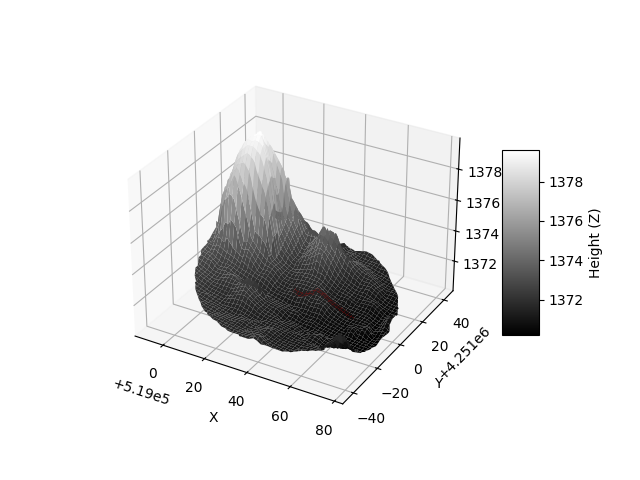

In [8]:
from scipy.interpolate import griddata

local_map = find_points_within_radius(start_point[:2], distance(start_point, end_point)*1.4)

# Create 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = local_map[:, 0]
y = local_map[:, 1]
z = local_map[:, 2]

grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Scatter plot (your point cloud)
#ax.plot_surface(local_map[:, 0], local_map[:, 1], local_map[:, 2], c='gray')



surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='gray', linewidth=0, antialiased=True)
ax.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], c='red', linewidth=3, label='Path')


# Optional: add colorbar
fig.colorbar(surf, shrink=0.5, aspect=5, label='Height (Z)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()